### 요구사항 1

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [18]:
class TitanicDataset(Dataset):
    # 텐서 자료형으로 데이터를 다루기 위해 각 Float와 Long 텐서로 변환
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    # 데이터셋 크기를 반환
    def __len__(self):
        return len(self.X)

    # feature와 target 데이터를 반환
    def __getitem__(self, idx):
        feature = self.X[idx]
        target = self.y[idx]
        return {'input': feature, 'target': target}

    # 데이터 사이즈에 대한 설명 반환
    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
            len(self.X), self.X.shape, self.y.shape
        )
        return str

In [19]:
class TitanicTestDataset(Dataset):
    # X를 FloatTensor로 변환
    def __init__(self, X):
        self.X = torch.FloatTensor(X)

    def __len__(self):
        # 데이터셋의 크기 반환
        return len(self.X)

    def __getitem__(self, idx):
        feature = self.X[idx]
        return {'input': feature}

    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}".format(
            len(self.X), self.X.shape
        )
        return str

In [30]:
def get_preprocessed_dataset():
    # 훈련 데이터와 테스트 데이터의 파일 경로 지정
    train_data_path = os.path.join("train.csv")
    test_data_path = os.path.join("test.csv")

    # DataFrame으로 각 CSV 파일을 읽어옴
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    # 정렬 안 하고 DataFrame을 합침
    all_df = pd.concat([train_df, test_df], sort=False)
    # 1 ~ 6까지 전처리 함수 호출
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)

    # Survived가 null이 아니라면 훈련 데이터로 사용하고, 기존 인덱스를 초기화하기 위해 reset_index 사용
    # 훈련 데이터에서는 Survived이 null이 아닌 행만을 선택하여 사용
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    # 학습해야 할 데이터인 Survived는 따로 추출해놓음
    train_y = train_df["Survived"]

    # 테스트 데이터에서는 Survived가 null인 행만을 선택하여 사용
    # 삭제하는 이유는 테스트에서는 Survived를 제거 -> 정답이 없기에
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # TitanicDataset을 이용해 학습용 데이터셋을 생성
    dataset = TitanicDataset(train_X.values, train_y.values)
    # print(dataset)
    # 훈련 데이터셋은 80%, 검증 데이터셋은 20%로 분할
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    # 테스트 데이터는 TitanicTestDataset으로 변환
    test_dataset = TitanicTestDataset(test_X.values)
    # print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

In [31]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df

In [32]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

In [33]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

In [34]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [35]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
        ~(
                (all_df["honorific"] == "Mr") |
                (all_df["honorific"] == "Miss") |
                (all_df["honorific"] == "Mrs") |
                (all_df["honorific"] == "Master")
        ),
        "honorific"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df

In [36]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
            le = le.fit(all_df[category_feature])
            all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

In [37]:
from torch import nn

class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()

        self.model = nn.Sequential(
            # 입력층에서 은닉층으로 넘어갈 땐 n_input에서 30개
            nn.Linear(n_input, 30),
            # 활성함수는 ReLU 사용
            nn.ReLU(),
            # 은닉층에서 은닉층은 30개에서 30개
            nn.Linear(30, 30),
            # 활성함수는 ReLU 사용
            nn.ReLU(),
            # 은닉층에서 출력층은 30개에서 2개
            nn.Linear(30, n_output),
        )

    # 모델 출력
    def forward(self, x):
        x = self.model(x)
        return x


In [38]:
def test(test_data_loader):
    print("[TEST]")
    batch = next(iter(test_data_loader))
    print("{0}".format(batch['input'].shape))

    # 여기선 입력층은 11개, 출력층은 2개
    my_model = MyModel(n_input=11, n_output=2)
    # 모델로 예측 수행
    output_batch = my_model(batch['input'])
    # 예측 데이터 출력
    prediction_batch = torch.argmax(output_batch, dim=1)
    for idx, prediction in enumerate(prediction_batch, start=892):
        print(idx, prediction.item())

In [39]:
if __name__ == "__main__":
    # 훈련, 검증, 테스트 데이터셋 생성
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

    print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
        len(train_dataset), len(validation_dataset), len(test_dataset)
    ))
    print("#" * 50, 1)

    for idx, sample in enumerate(train_dataset):
        print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

    print("#" * 50, 2)

    # 훈련 데이터셋을 DataLoader에 넣음, 배치 사이즈는 16으로, 데이터를 섞어서 사용
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    # 검증 데이터셋을 배치 사이즈 16으로, 데이터를 섞어서 사용
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
    # 테스트 데이터셋은 한 번에 출력함(배치 사이즈가 테스트 데이터셋 크기)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

    # 훈련 데이터를 배치 크기 단위로 출력
    print("[TRAIN]")
    for idx, batch in enumerate(train_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

    # 검증 데이터를 배치 크기 단위로 출력
    print("[VALIDATION]")
    for idx, batch in enumerate(validation_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

    print("#" * 50, 3)

    # 테스트 데이터의 예측 수행
    test(test_data_loader)

train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 1.0000,  1.0000, 45.0000,  0.0000,  0.0000, 26.5500,  2.0000, 87.5090,
         4.0000,  0.0000,  1.0000]): 0
1 - tensor([ 3.0000,  1.0000, 21.0000,  0.0000,  0.0000,  7.2500,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
2 - tensor([ 3.0000,  1.0000, 29.0000,  0.0000,  0.0000,  8.0500,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
3 - tensor([ 1.0000,  0.0000, 24.0000,  0.0000,  0.0000, 69.3000,  0.0000, 87.5090,
         4.0000,  0.0000,  1.0000]): 1
4 - tensor([ 2.0000,  1.0000, 52.0000,  0.0000,  0.0000, 13.0000,  2.0000, 21.1792,
         2.0000,  0.0000,  1.0000]): 0
5 - tensor([ 1.0000,  1.0000, 49.0000,  1.0000,  0.0000, 56.9292,  0.0000, 87.5090,
         4.0000,  1.0000,  0.0000]): 1
6 - tensor([ 2.0000,  1.0000, 25.0000,  0.0000,  0.0000, 13.0000,  2.0000, 21.1792,
         2.0000,  0.0000,  1.0000]): 0
7 - tensor([ 3.00

### 요구사항 2. 타이타닉 데이터로 코드 수정하기

In [ ]:
# 수정한 코드는 한 덩어리로 올렸습니다.
# 실행은 PyCharm에서 해서, Jupiter에선 실행하지 않았습니다.
import os
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
import wandb
import argparse

class TitanicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class TitanicTestDataset(Dataset):
    def __init__(self, features):
        self.features = torch.tensor(features, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

# 기존 titanic_dataset을 활용
def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    train_dataset = TitanicDataset(train_X.values, train_y.values)
    train_dataset, validation_dataset = random_split(train_dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)

    return train_dataset, validation_dataset, test_dataset

# 모델 수정을 많이 거쳤음
# 배치 정규화를 사용했고, 결과에서 가장 괜찮게 나왔다고 생각한 값은 PReLU여서 활성화 함수는 PReLU를 사용했음
# Dropout을 사용하여 생길 수 있는 오버피팅의 문제를 해결했음. 0.3~0.5중에서 0.4가 가장 Valid_less가 작았음
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 64),
            nn.BatchNorm1d(64),
            nn.PReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.PReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.PReLU(),
            nn.Linear(32, n_output),
        )

    def forward(self, x):
        return self.model(x)

def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))

    # 훈련 데이터와 테스트 데이터의 파일 경로 지정
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    # DataFrame으로 각 CSV 파일을 읽어옴
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    # 정렬 안 하고 DataFrame을 합침
    all_df = pd.concat([train_df, test_df], sort=False)
    # 1 ~ 6까지 전처리 함수 호출
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)

    # Survived가 null이 아니라면 훈련 데이터로 사용하고, 기존 인덱스를 초기화하기 위해 reset_index 사용
    # 훈련 데이터에서는 Survived이 null이 아닌 행만을 선택하여 사용
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    # 학습해야 할 데이터인 Survived는 따로 추출해놓음
    train_y = train_df["Survived"]

    # 테스트 데이터에서는 Survived가 null인 행만을 선택하여 사용
    # 삭제하는 이유는 테스트에서는 Survived를 제거 -> 정답이 없기에
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # TitanicDataset을 이용해 학습용 데이터셋을 생성
    dataset = TitanicDataset(train_X.values, train_y.values)
    # print(dataset)
    # 훈련 데이터셋은 80%, 검증 데이터셋은 20%로 분할
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    # 테스트 데이터는 TitanicTestDataset으로 변환
    test_dataset = TitanicTestDataset(test_X.values)
    # print(test_dataset)

    return train_dataset, validation_dataset, test_dataset


def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df


def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df


def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df


def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df


def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
        ~(
                (all_df["honorific"] == "Mr") |
                (all_df["honorific"] == "Miss") |
                (all_df["honorific"] == "Mrs") |
                (all_df["honorific"] == "Master")
        ),
        "honorific"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df


def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
            le = le.fit(all_df[category_feature])
            all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

# 예측값 저장 메소드
def predict_and_save(model, test_loader, filename="submission.csv"):
    # 모델 평가 모드로 설정, 레이어가 훈련 모드가 아닌 고정된 모드로 지정
    model.eval()
    predictions = []

    # 역전파 수행 X -> 예측속도 증가
    with torch.no_grad():
        # 미니 배치 기준으로 입력을 받고, 예측 결과를 얻음
        for inputs in test_loader:
            outputs = model(inputs)
            # 행 기준 각 샘플의 최대값 찾음
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())

    # submission.csv 생성
    # 승객 번호는 892번부터 시작, 예측 번호를 할당
    submission = pd.DataFrame({"PassengerId": range(892, 892 + len(predictions)), "Survived": predictions})
    submission.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

# 모델 최적화 함수
def get_model_and_optimizer(n_input):
    # 이진 분류(0 또는 1)를 실행
    model = MyModel(n_input=n_input, n_output=2)
    # Wandb를 통하여 학습률을 받아서 사용
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
    return model, optimizer

def training_loop(model, optimizer, train_loader, val_loader, test_loader):
    # 분류문제에서 자주 사용하는 CrossEntorypyLoss 함수를 사용
    loss_fn = nn.CrossEntropyLoss()
    n_epochs = wandb.config.epochs

    # 초기값 설정
    best_val_loss = float('inf')
    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss, total = 0, 0

        # 훈련 단계
        for inputs, targets in train_loader:
            # 입력에 대한 예측 수행
            outputs = model(inputs)
            # 입력에 대한 loss 계산
            loss = loss_fn(outputs, targets)

            # 이전 gradient 초기화
            optimizer.zero_grad()
            # gradient를 역전파를 수행하여 정의
            loss.backward()
            # 파라미터를 업데이트 함
            optimizer.step()

            total_loss += loss.item()
            total += 1

        val_loss, val_total = 0, 0
        # 모델 평가모드로 변경
        model.eval()
        # 평가 중에는 gradient 변화 X
        with torch.no_grad():
            for inputs, targets in val_loader:
                # 검증 데이터 예측
                outputs = model(inputs)
                # loss 계산
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
                val_total += 1

        # wandb에 로그를 기록
        wandb.log({
            "epoch": epoch,
            "train_loss": total_loss / total,
            "val_loss": val_loss / val_total
        })

        # Validation loss가 개선될 때마다 테스트 예측 수행
        # 여기서 위에서 서술한 predict_and_save 메소드를 수행
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"Epoch {epoch}, New Best Val Loss: {val_loss / val_total}.")
            predict_and_save(model, test_loader)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Train Loss: {total_loss / total}, Val Loss: {val_loss / val_total}")

def main(args):
    wandb.init(
        project="titanic_model",
        # lr을 1e-3 -> 1e-4로 변경(값 변동이 너무 커서)
        config={
            "epochs": args.epochs,
            "batch_size": args.batch_size,
            "learning_rate": 1e-4,
        }
    )
    # test_dataset을 추가
    train_dataset, val_dataset, test_dataset = get_preprocessed_dataset()

    # shuffle을 이용하여 데이터를 섞어서 사용
    train_loader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=wandb.config.batch_size)
    test_loader = DataLoader(test_dataset, batch_size=wandb.config.batch_size)

    # 입력 차원을 받아서 model, optimizer를 생성
    model, optimizer = get_model_and_optimizer(n_input=train_dataset[0][0].shape[0])
    # 모델, optimizer, train_loader, val_loader, test_loader를 넣고 훈련 시작
    training_loop(model, optimizer, train_loader, val_loader, test_loader)

    wandb.finish()

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=1000)
    parser.add_argument("--batch_size", type=int, default=64)
    args = parser.parse_args()
    main(args)

### 요구사항 2. Wandb 링크 걸기

In [ ]:
# ReLU - https://wandb.ai/duehee-korea-university-of-technology-and-education/titanic_model/runs/j8rij9ow
# PReLU - https://wandb.ai/duehee-korea-university-of-technology-and-education/titanic_model/runs/sik3hxfc
# ReakyReLU - https://wandb.ai/duehee-korea-university-of-technology-and-education/titanic_model/runs/yeejbq0y
# ELU - https://wandb.ai/duehee-korea-university-of-technology-and-education/titanic_model/runs/lxr9zm7h
    
# 제시한 활성함수를 모두 사용해보았다. 

### 요구사항 2. 더 나은 결과를 제공하는 활성화 함수 생각하기

In [ ]:
# 사용해 본 결과는 아래와 같다.
# ReLU : Train_loss와 Valid_loss가 평균이다. 각 loss의 차이가 크지 않아 이상적이다.
# PReLU : 압도적으로 Valid_loss가 작게 나왔다. Valid_loss가 작을수록 훈련 데이터에 크게 영향을 받지 않는다고 하여 위에선 PReLU를 사용했다.
# ReakyReLU : Train_loss가 가장 작게 나온 값이었다. 4개 중엔 Loss의 차이가 가장 컸다.
# ELU : 각 loss의 차이가 크진 않았지만, 그렇다고 특출나지 않은 결과를 보여서 사용하진 않았다.

### 요구사항 3. 가장 좋은 활성화 함수로 모델 구현하기

In [ ]:
# 요구사항 2에서 PReLU로 구현헀다.
# 어느 Epoch가 가장 좋은가? -> 테스트 과정에서는 Valid_loss가 최소인 값을 best 값이라고 생각하고 값을 적용하고 저장했다.
# 그 내용은 추가적으로 training_loop 및 predict_and_save 메소드를 이용하여 구현했다.
# submission.scv도 생성하여 Kaggle에 제출했다.

### 요구사항 4. Kaggle에 제출 및 등수 확인

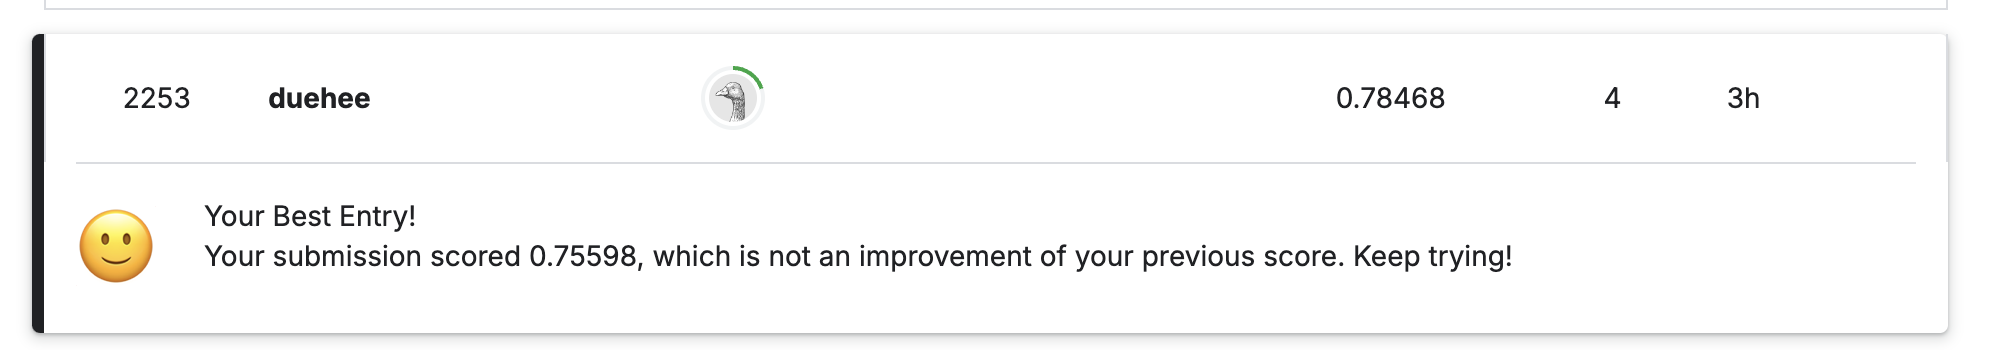

In [68]:
from IPython.display import Image, display
display(Image(filename="Kaggle.png"))